# Library

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score

Function that plots the bars of accuracy between 2 preset of parameters

In [92]:
def plot_grouped_accuracy_bars(first_results: pd.Series, second_results: pd.Series, first_label, second_label):
    """
    Plots a grouped bar chart comparing accuracy between two models from two pd.Series.

    Args:
        first_results (pd.Series): First series with index as categories and values as accuracy.
        second_results (pd.Series): Second series with the same structure.
        first_label (str): Label for the first series.
        second_label (str): Label for the second series.
    """
    # Align indexes just in case
    common_index = first_results.index.intersection(second_results.index)
    
    first_values = first_results.loc[common_index].values
    second_values = second_results.loc[common_index].values
    
    categories = common_index.tolist()

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width / 2, first_values, width, label=first_label, hatch='///', color='skyblue', edgecolor='black')
    bars2 = ax.bar(x + width / 2, second_values, width, label=second_label, hatch='\\\\\\', color='lightcoral', edgecolor='black')

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

Function that extract the winning of the model (set the label for the winner)

In [93]:
def extract_winning(result_df: pd.DataFrame, win_label="CHATGPT", lose_label="VICUNA13B", tie_label="TIE"):
    extract_df = result_df.copy()

    extract_df['win_res'] = extract_df['score'].apply(lambda x: x[0] - x[1])
    extract_df['win_res'] = extract_df['win_res'].apply(
        lambda x: win_label if x > 0 else lose_label if x < 0 else tie_label)

    return extract_df

# Check mean accuracy and kappa coefficient
In this chapter we recheck the results gained from the repeated experiments to check the similarity of:
- mean **accuracy** with labels provided by the humans
- **kappa correlation coefficient** with ground-truth (labels from the humans)  

Read the questions and remain only their `category`

In [94]:
questions = pd.read_json('question.jsonl', lines=True)
questions = questions.set_index('question_id').drop(['text'], axis=1)
questions

,category
question_id,
1,generic
2,generic
3,generic
4,generic
5,generic
...,...
76,writing
77,writing
78,writing


Read and merge the results of human assessing as `ground_truth` for the further calculations 

In [95]:
with open('./review/review_gpt35_vicuna-13b_human.txt', 'r', encoding='utf-8') as f:
    text_lines = f.read().splitlines()

len(text_lines)

80

In [96]:
questions['ground_truth'] = text_lines
questions

,category,ground_truth
question_id,,
1,generic,CHATGPT
2,generic,TIE
3,generic,VICUNA13B
4,generic,VICUNA13B
5,generic,VICUNA13B
...,...,...
76,writing,CHATGPT
77,writing,CHATGPT
78,writing,CHATGPT


Read the results of experiments into one 

In [97]:
judgement_result = {
    'gpt4_k_1_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-4_mec1_bpc0.jsonl', lines=True).set_index(
        'question_id'),
    'gpt4_k_3_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-4_mec3_bpc0.jsonl', lines=True).set_index(
        'question_id'),
    'gpt4_k_6_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-4_mec6_bpc0.jsonl', lines=True).set_index(
        'question_id'),
    'gpt4_k_3_bpc_1_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-4_mec3_bpc1.jsonl', lines=True).set_index(
        'question_id'),
    'gpt35_k_1_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                        lines=True).set_index(
        'question_id'),
    'gpt35_k_3_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc0.jsonl',
                                        lines=True).set_index(
        'question_id'),
    'gpt35_k_6_bpc_0_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec6_bpc0.jsonl',
                                        lines=True).set_index(
        'question_id'),
    'gpt35_k_3_bpc_1_t_1': pd.read_json('./review/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                        lines=True).set_index(
        'question_id'),
}

judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]"
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]"
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]"
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]"
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]"
...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]"
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]"
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]"


Extract **winner** of judgement:
* if the `first score > second score` -> CHATGPT
* if the `first score < second score` -> VICUNA13B
* if the `first score == second score` -> TIE

In [98]:
for idx, df in judgement_result.items():
    judgement_result[idx] = pd.concat([questions, extract_winning(df)], axis=1)

judgement_result['gpt4_k_1_bpc_0_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,win_res
question_id,,,,,,,,
1,generic,CHATGPT,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT
2,generic,TIE,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B
3,generic,VICUNA13B,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT
4,generic,VICUNA13B,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",TIE
5,generic,VICUNA13B,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",TIE
...,...,...,...,...,...,...,...,...
76,writing,CHATGPT,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT
77,writing,CHATGPT,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT
78,writing,CHATGPT,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT


Create **flag** == `ground_truth` == `win_res` for accuracy calculations

In [99]:
for df in judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['win_res']

judgement_result['gpt4_k_1_bpc_0_t_1']

,category,ground_truth,question,review,review_bpc,cost,score,win_res,result_hit
question_id,,,,,,,,,
1,generic,CHATGPT,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT,True
2,generic,TIE,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B,False
3,generic,VICUNA13B,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT,False
4,generic,VICUNA13B,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",TIE,False
5,generic,VICUNA13B,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",TIE,False
...,...,...,...,...,...,...,...,...,...
76,writing,CHATGPT,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT,True
77,writing,CHATGPT,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT,True
78,writing,CHATGPT,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT,True


Calculate `accuracy` (percentage of matches between ground-truth and judgement) in the map

In [100]:
accuracy_map = {}

for idx, df in judgement_result.items():
    accuracy_map[idx] = df["result_hit"].mean() * 100

accuracy_map

{'gpt4_k_1_bpc_0_t_1': np.float64(58.75),
 'gpt4_k_3_bpc_0_t_1': np.float64(61.25000000000001),
 'gpt4_k_6_bpc_0_t_1': np.float64(60.0),
 'gpt4_k_3_bpc_1_t_1': np.float64(60.0),
 'gpt35_k_1_bpc_0_t_1': np.float64(62.5),
 'gpt35_k_3_bpc_0_t_1': np.float64(60.0),
 'gpt35_k_6_bpc_0_t_1': np.float64(61.25000000000001),
 'gpt35_k_3_bpc_1_t_1': np.float64(58.75)}

Calculate `kappa correlation coefficient` in the map

In [101]:
kappa_map = {}

for idx, df in judgement_result.items():
    kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["win_res"])
    
kappa_map

{'gpt4_k_1_bpc_0_t_1': np.float64(0.3178294573643411),
 'gpt4_k_3_bpc_0_t_1': np.float64(0.33494234379190124),
 'gpt4_k_6_bpc_0_t_1': np.float64(0.29939792008757526),
 'gpt4_k_3_bpc_1_t_1': np.float64(0.32790758729325276),
 'gpt35_k_1_bpc_0_t_1': np.float64(0.36390140471773114),
 'gpt35_k_3_bpc_0_t_1': np.float64(0.29728245951139176),
 'gpt35_k_6_bpc_0_t_1': np.float64(0.32129173508483844),
 'gpt35_k_3_bpc_1_t_1': np.float64(0.33501259445843834)}

## Drawing conclusions

Define description map for every preset of parameters

In [102]:
DESCRIPTION_MAP = {
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_3_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3)'
    },
    'gpt4_k_6_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 6)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3)'
    },
    'gpt35_k_6_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 6)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

Create a final judgement table

In [103]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in DESCRIPTION_MAP.values()],
    "accuracy": accuracy_map.values(),
    "kappa": kappa_map.values(),
}, index=accuracy_map.keys())

final_table

,judge,description,accuracy,kappa
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),58.75,0.317829
gpt4_k_3_bpc_0_t_1,GPT-4,MEC (k = 3),61.25,0.334942
gpt4_k_6_bpc_0_t_1,GPT-4,MEC (k = 6),60.00,0.299398
gpt4_k_3_bpc_1_t_1,GPT-4,MEC (k = 3) + BPC (k = 3),60.00,0.327908
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),62.50,0.363901
gpt35_k_3_bpc_0_t_1,GPT-3.5,MEC (k = 3),60.00,0.297282
gpt35_k_6_bpc_0_t_1,GPT-3.5,MEC (k = 6),61.25,0.321292
gpt35_k_3_bpc_1_t_1,GPT-3.5,MEC (k = 3) + BPC (k = 3),58.75,0.335013


![Paper results](./fig/first_experiment.png)

# Check categories accuracy
In this chapter I try to repeat check for the results between different **categories** of questions

Two preset are going to be compared:
1. **EC (k = 1)** - the worst option except for Vanilla (according to paper)
2. **MEC (k = 3) + BPC (k = 3)** - the best option without human participation (according to paper)

In [104]:
BEST_PARAMETERS_SET = 'k_3_bpc_1_t_1'

In [105]:
WORST_PARAMETERS_SET = 'k_1_bpc_0_t_1'

## GPT-4
Extract accuracy grouped by categories in the worst and best cases for **GPT-4**

In [106]:
gpt4_best_category_acc = judgement_result[f"gpt4_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()
gpt4_best_category_acc

category
coding            0.714286
common-sense      0.600000
counterfactual    0.400000
fermi             0.600000
generic           0.600000
knowledge         0.500000
math              0.666667
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

In [107]:
gpt4_worst_category_acc = judgement_result[f"gpt4_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt4_worst_category_acc

category
coding            1.000000
common-sense      0.700000
counterfactual    0.500000
fermi             0.600000
generic           0.400000
knowledge         0.300000
math              0.666667
roleplay          0.500000
writing           0.800000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

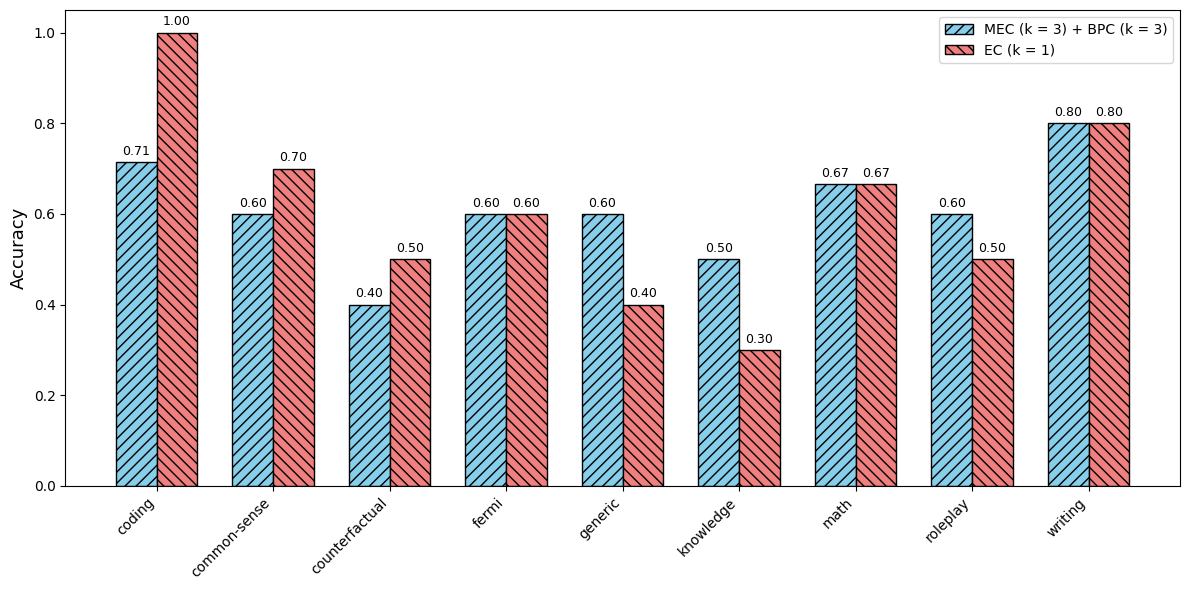

In [108]:
plot_grouped_accuracy_bars(gpt4_best_category_acc, gpt4_worst_category_acc, second_label="EC (k = 1)", first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt4_categories.png)

## GPT 3.5
Calculate the accuracy across categories for GPT 3.5

In [109]:
gpt3_5_best_category_acc = judgement_result[f"gpt35_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_best_category_acc

category
coding            0.857143
common-sense      0.600000
counterfactual    0.500000
fermi             0.500000
generic           0.600000
knowledge         0.500000
math              0.666667
roleplay          0.400000
writing           0.800000
Name: result_hit, dtype: float64

In [110]:
gpt3_5_worst_category_acc = judgement_result[f"gpt35_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_worst_category_acc

category
coding            0.714286
common-sense      0.700000
counterfactual    0.600000
fermi             0.500000
generic           0.500000
knowledge         0.600000
math              1.000000
roleplay          0.500000
writing           0.800000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

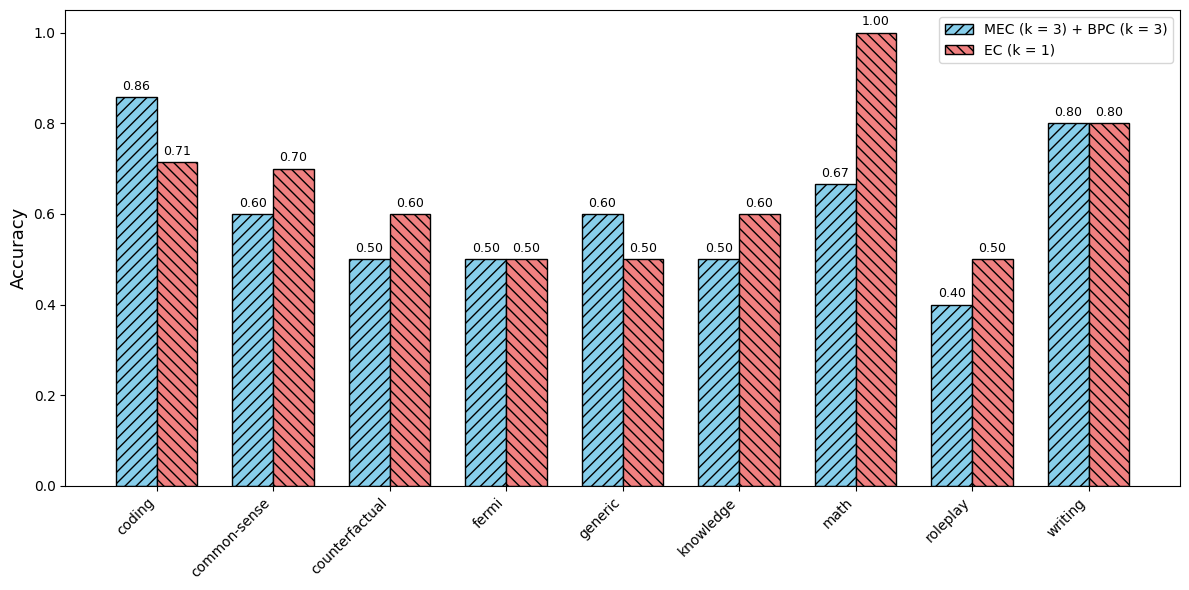

In [111]:
plot_grouped_accuracy_bars(gpt3_5_best_category_acc, gpt3_5_worst_category_acc, second_label="EC (k = 1)", first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt3_5_categories.png)